Etsy Handmade Shops – Exploratory Data Analysis (EDA)
This notebook performs exploratory data analysis (EDA) on a cleaned dataset of Etsy handmade shops.
The main goals are to:
- explore where mostly shops are located,
- understand how shop attributes (age, number of listings, engagement) relate to sales,
- compare shops with and without marketing messages,
- prepare the data for simple predictive modelling of sales.

In [71]:
# BASIC DATA HANDLING
import pandas as pd
import numpy as np

# VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# MACHINE LEARNING (optional – for simple regression)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Settings for nicer plots
sns.set(style="whitegrid")


Load cleaned dataset and basic overview of structure and basic statistics

In [4]:
df = pd.read_csv('../data/etsy_shops_data_cleaned.csv')
print("Dataset shape:", df.shape)
display(df.head())
print("\nDataset info:")
df.info()
print("\nStatistical summary:")
display(df.describe())


Dataset shape: (6313, 9)


,creation_date,listing_active_count,num_favorers,currency_code,sale_message,sales_count,review_count,shop_location,country
0,19-Nov,3,1,USD,False,0,0,"Kansas City, Missouri",United States
1,19-Nov,40,1,USD,False,0,0,"Kharkiv, Ukraine",Ukraine
2,19-Nov,7,1,USD,False,0,0,"New York, United States",United States
3,19-Nov,12,2,USD,False,0,0,"Tel Aviv, Israel",Israel
4,19-Nov,12,6,USD,True,1,0,"Pittsburgh, Pennsylvania",United States



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6313 entries, 0 to 6312
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   creation_date         6313 non-null   object
 1   listing_active_count  6313 non-null   int64 
 2   num_favorers          6313 non-null   int64 
 3   currency_code         6313 non-null   object
 4   sale_message          6313 non-null   bool  
 5   sales_count           6313 non-null   int64 
 6   review_count          6313 non-null   int64 
 7   shop_location         6313 non-null   object
 8   country               6313 non-null   object
dtypes: bool(1), int64(4), object(4)
memory usage: 400.9+ KB

Statistical summary:


,listing_active_count,num_favorers,sales_count,review_count
count,6313.000000,6313.000000,6313.000000,6313.000000
mean,10.677966,1.521147,2.866149,0.143038
std,32.348287,4.781198,27.823907,1.035479
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000,0.000000
75%,11.000000,2.000000,1.000000,0.000000
max,1749.000000,223.000000,1508.000000,58.000000


Distributions of key numerical variables 
Here I explore the distributions of the main numerical variables:
- `sales_count` – total number of sales
- `listing_active_count` – number of active listings
- `num_favorers` – number of users who have favourited the shop
- `review_count` – number of reviews

This helps identify skewness, outliers and the general scale of each variable.


Descriptive statistics for sales_count:
count    6313.000000
mean        2.866149
std        27.823907
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max      1508.000000
Name: sales_count, dtype: float64

Descriptive statistics for listing_active_count:
count    6313.000000
mean       10.677966
std        32.348287
min         0.000000
25%         2.000000
50%         5.000000
75%        11.000000
max      1749.000000
Name: listing_active_count, dtype: float64

Descriptive statistics for num_favorers:
count    6313.000000
mean        1.521147
std         4.781198
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max       223.000000
Name: num_favorers, dtype: float64

Descriptive statistics for review_count:
count    6313.000000
mean        0.143038
std         1.035479
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        58.000000
Name: review_count, dtype: float64


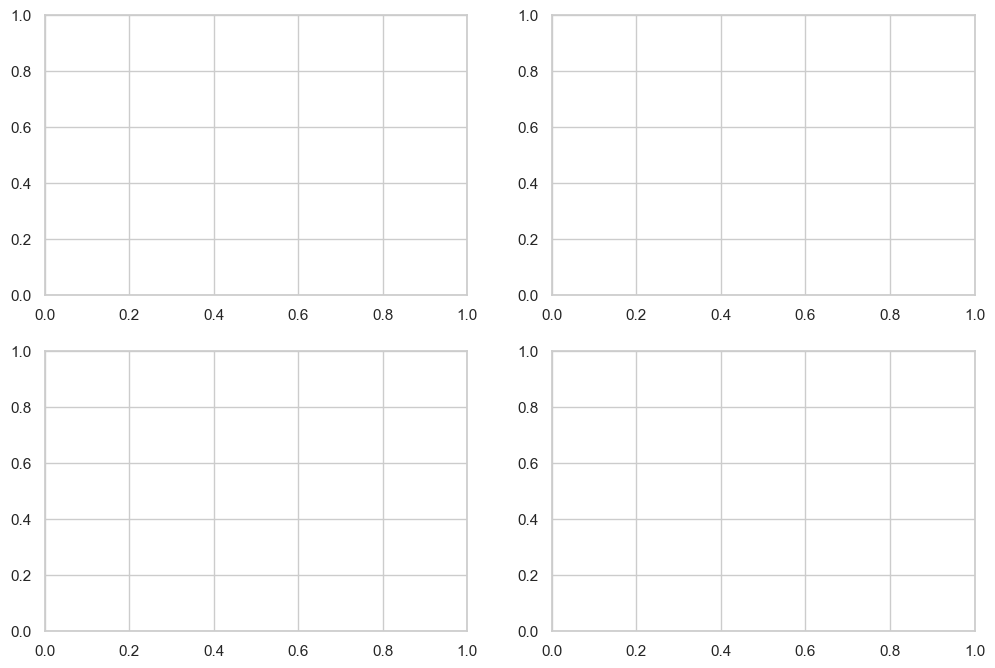

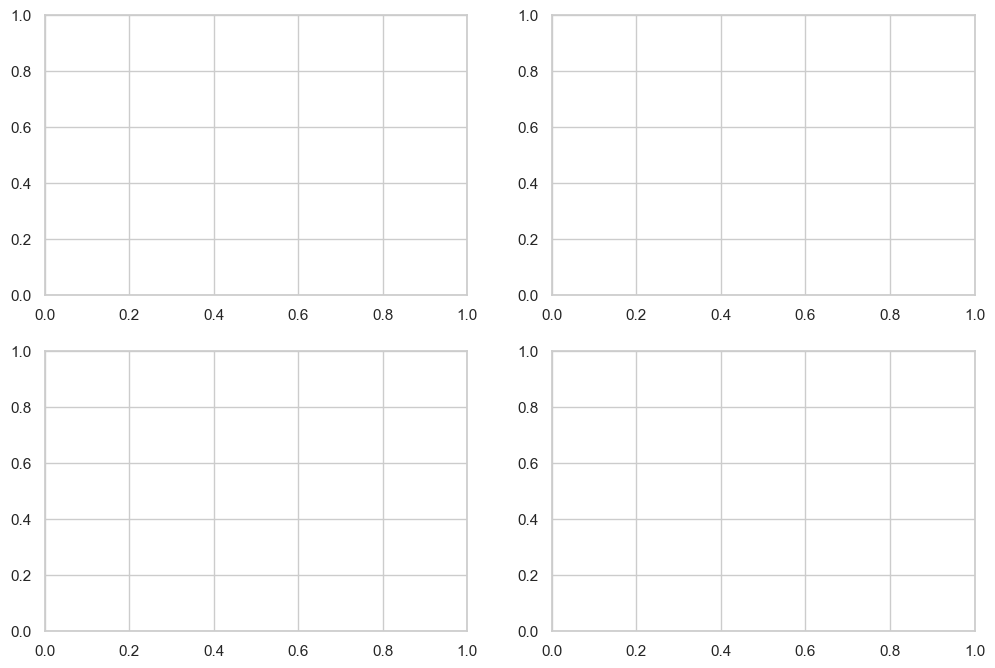

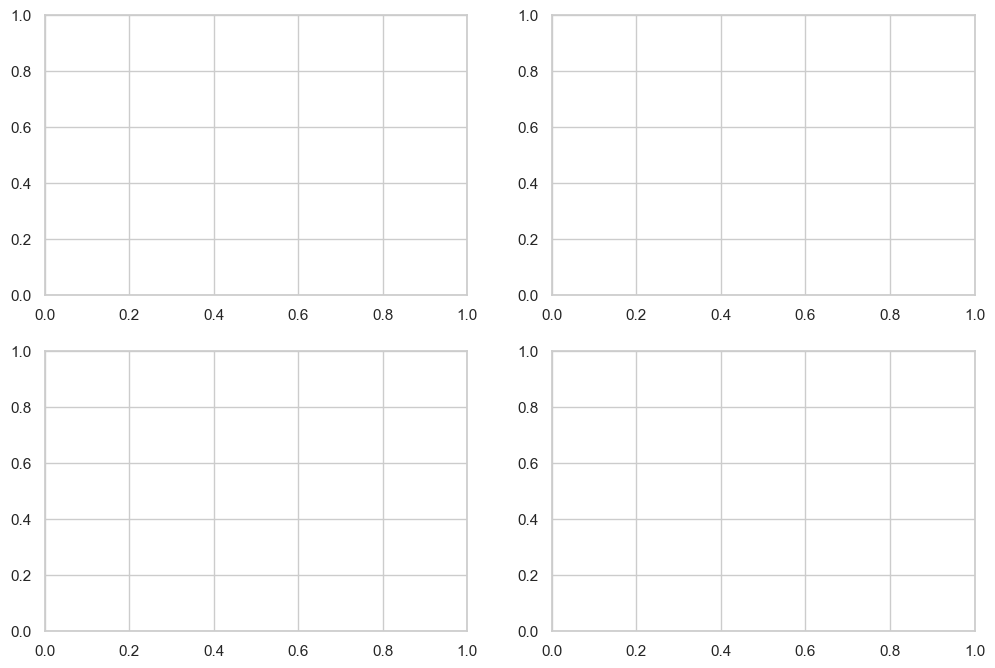

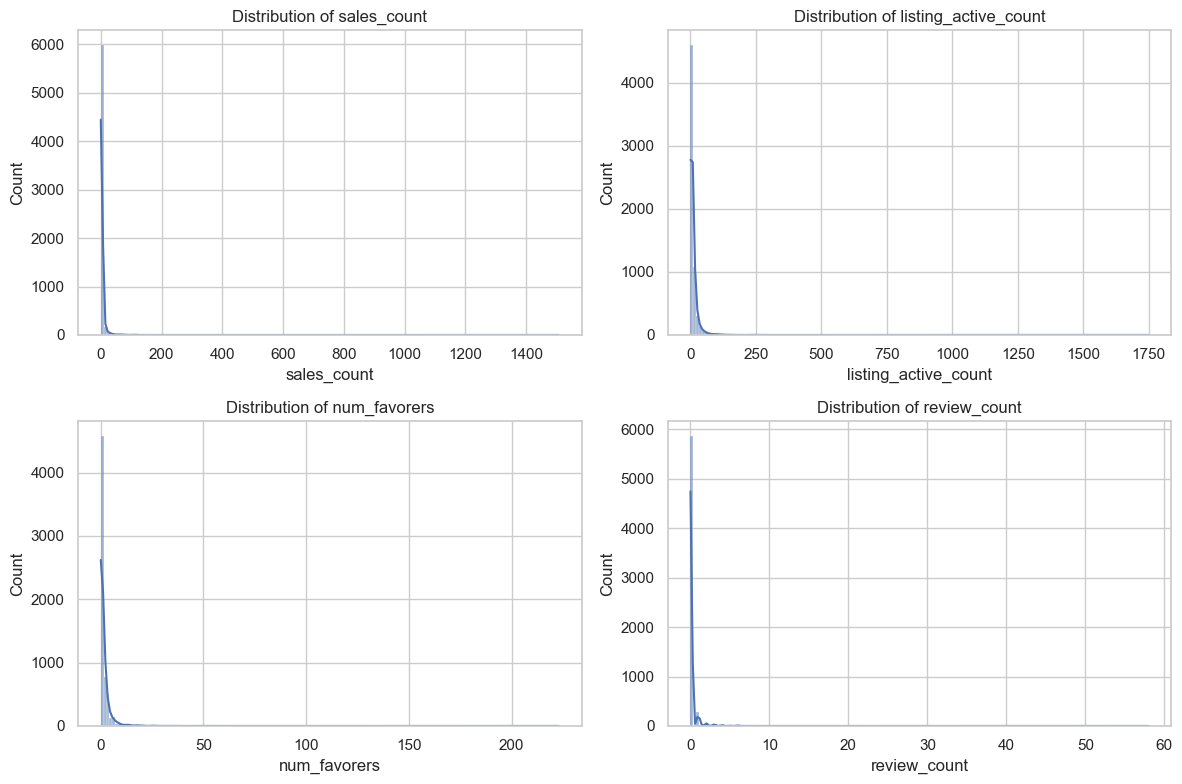

In [9]:
# find the numerical columns
numerical_cols = ['sales_count', 'listing_active_count', 'num_favorers', 'review_count']
# print descriptive statistics  for numerical columns and create histograms
for col in numerical_cols:
    print(f"\nDescriptive statistics for {col}:")
    print(df[col].describe())
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, numerical_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()  

Number of shops by country

H1: Shop performance varies by countries 
Hypothesis: Find out which location may influence higher sales, due to larger customer markets. 
Figure 1: Number of shops by countries (bar chart) - to make chart more visually clear I decided to group countries by number of shops
Figure 2: Sales distribution per countires (boxplot) - top 15 countires (Figure 2A - USA, Figure 2B-rest of top 14)

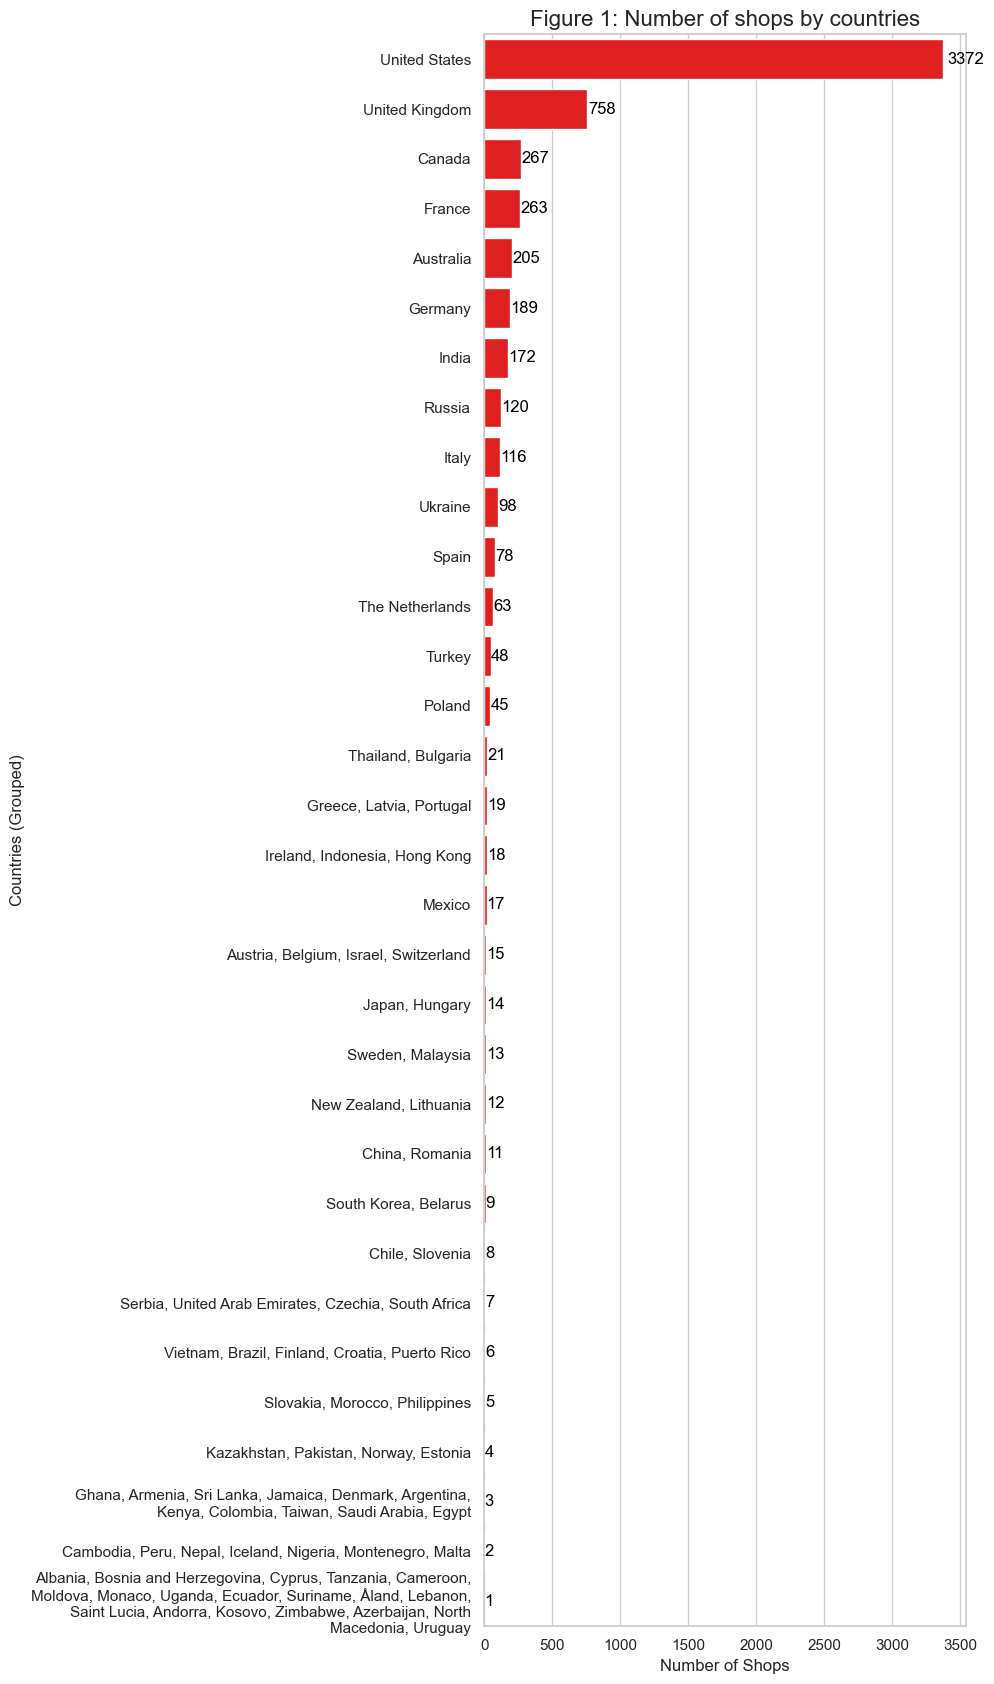

C:\Users\Karolina\AppData\Local\Temp\ipykernel_21328\2993142971.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['country'].isin(top_countries)], x='sales_count', y='country', palette="Set3")


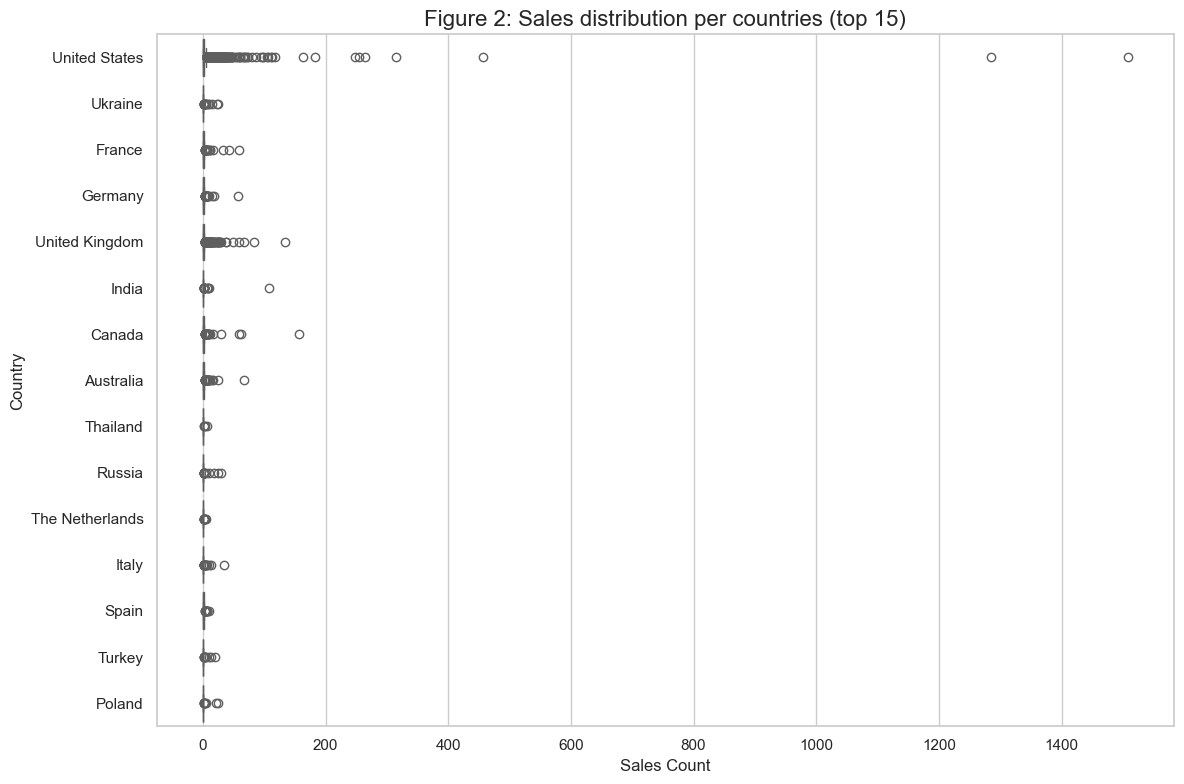

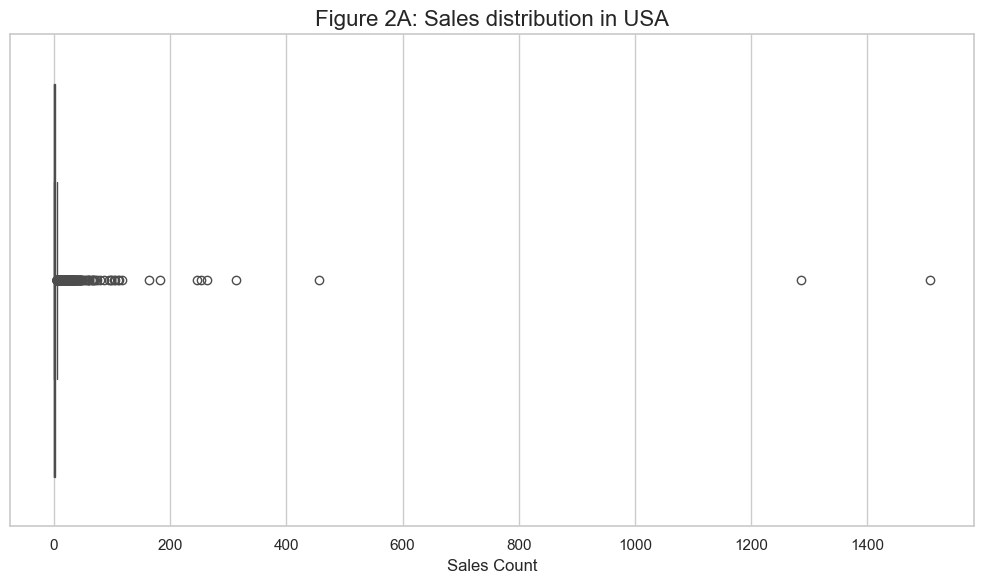

C:\Users\Karolina\AppData\Local\Temp\ipykernel_21328\2993142971.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top14, x='sales_count', y='country', palette='Reds_r')


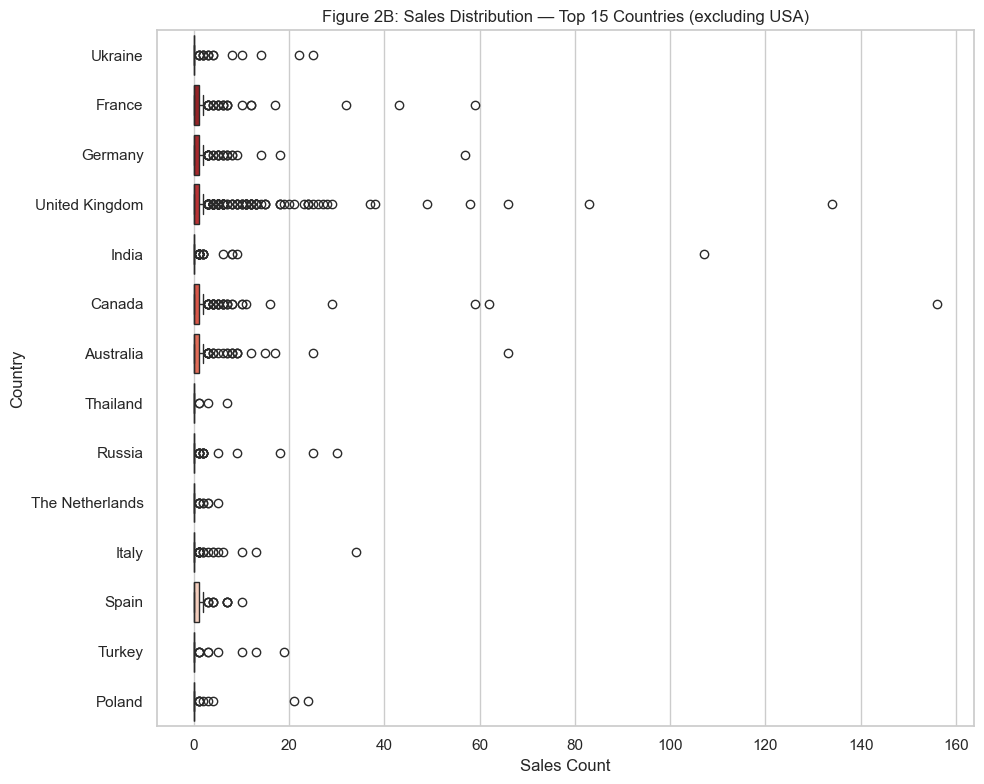

In [54]:
import textwrap
# number of shops by country
plt.figure(figsize=(10, 17))
country_counts = df['country'].value_counts()
#group countries by number of shops to make chart more visually clear
grouped_counts = country_counts.groupby(country_counts).apply(lambda x: ', '.join(x.index))
#sort shops descending by number of shops
grouped_counts = grouped_counts.sort_index(ascending=False)
#wrap long country name lists (over 50 characters) for better display
grouped_wrapped = grouped_counts.apply(lambda txt: "\n".join(textwrap.wrap(txt, width=60)))
sns.barplot(x=grouped_counts.index, y=grouped_wrapped.values, color="red")
#add shop counts to the ends of the bars
for i, count in enumerate(grouped_counts.index):
    plt.text(count * 1.01, i, str(count), va='center', ha='left', fontsize=12, color='black')
plt.title("Figure 1: Number of shops by countries", fontsize=16)
plt.xlabel("Number of Shops", fontsize=12)
plt.ylabel("Countries (Grouped)", fontsize=12)
plt.tight_layout()
plt.show()
# sales distribution per countries (top 15)
top_countries = df['country'].value_counts().nlargest(15).index
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[df['country'].isin(top_countries)], x='sales_count', y='country', palette="Set3")
plt.title("Figure 2: Sales distribution per countries (top 15)", fontsize=16)
plt.xlabel("Sales Count", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.tight_layout()
plt.show()
#figure 2A - USA
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['country'] == 'United States'], x='sales_count', color="red")
plt.title("Figure 2A: Sales distribution in USA", fontsize=16)
plt.xlabel("Sales Count", fontsize=12)
plt.tight_layout()
plt.show()
#figure 2B - rest of top 14
top15 = df['country'].value_counts().head(15).index
df_top14 = df[df['country'].isin(top15) & (df['country'] != 'United States')]
plt.figure(figsize=(10, 8))
sns.boxplot(data=df_top14, x='sales_count', y='country', palette='Reds_r')
plt.title("Figure 2B: Sales Distribution — Top 15 Countries (excluding USA)")
plt.xlabel("Sales Count")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


H2: Sales increase with number of active listings 
Hypothesis: Shops with more active products generate more sales. 
Figure 3: Sales Count vs Number of Listings (scatterplot with trendline)

C:\Users\Karolina\AppData\Local\Temp\ipykernel_21328\3433816680.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


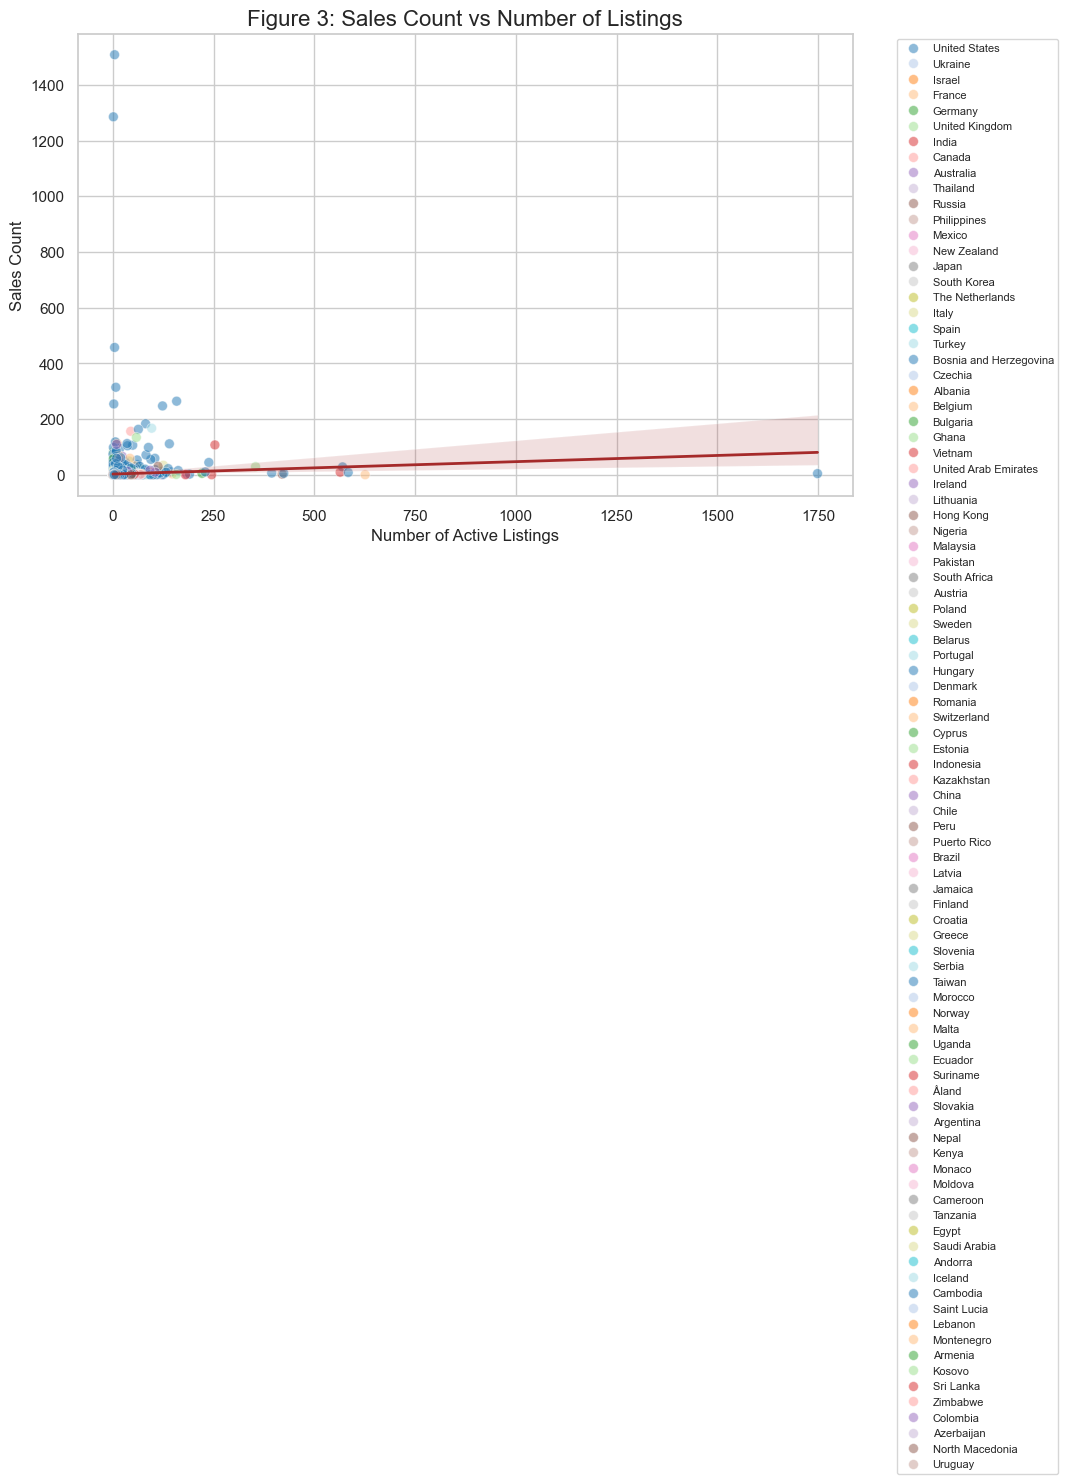

In [84]:
# sales vs number of listings (scatterplot with trendline)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='listing_active_count', y='sales_count', hue='country', palette='tab20',alpha=0.5,s=50)
sns.regplot(x='listing_active_count', y='sales_count', data=df, scatter=False, color='brown', line_kws={"linewidth":2})
plt.title("Figure 3: Sales Count vs Number of Listings", fontsize=16)           
plt.xlabel("Number of Active Listings", fontsize=12)
plt.ylabel("Sales Count", fontsize=12)
#legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


H3: Shops with marketing enabled (“sale_message = TRUE”) perform better 
Hypothesis: Shops using marketing or promotion messages achieve higher sales and more reviews. 
Figure 4: Sales by Marketing Status (boxplot) 
Figure 5: Reviews vs Marketing Status (bar chart)

C:\Users\Karolina\AppData\Local\Temp\ipykernel_21328\3240663581.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='marketing_status', y='sales_count', estimator='median', errorbar=None, palette=['#d95f02', '#1b9e77'])


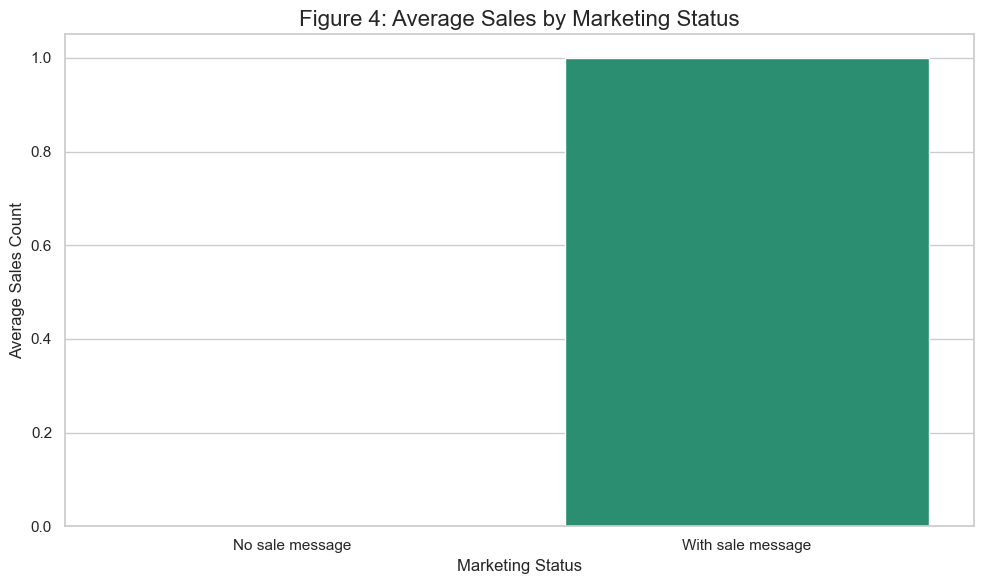

C:\Users\Karolina\AppData\Local\Temp\ipykernel_21328\3240663581.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=reviews_by_marketing, x='marketing_status', y='review_count', palette="Reds_r")


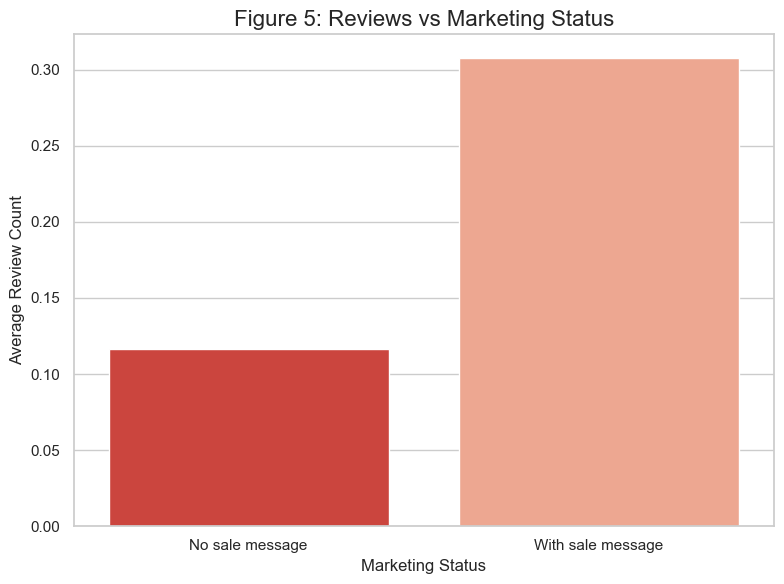

In [102]:
#ceate a cleaner categorical column for marketing status
df['marketing_status'] = df['sale_message'].map({True: 'With sale message', False: 'No sale message'})
df['marketing_status'] = df['marketing_status'].fillna('No sale message')
df['marketing_status'].value_counts()

#sales by marketing status (bar chart)
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='marketing_status', y='sales_count', estimator='median', errorbar=None, palette=['#d95f02', '#1b9e77'])
plt.title("Figure 4: Average Sales by Marketing Status", fontsize=16)
plt.xlabel("Marketing Status", fontsize=12)
plt.ylabel("Average Sales Count", fontsize=12)
plt.tight_layout()
plt.show()

#reviews vs marketing status (bar chart)
reviews_by_marketing = df.groupby('marketing_status')['review_count'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(data=reviews_by_marketing, x='marketing_status', y='review_count', palette="Reds_r")
plt.title("Figure 5: Reviews vs Marketing Status", fontsize=16)
plt.xlabel("Marketing Status", fontsize=12)
plt.ylabel("Average Review Count", fontsize=12)
plt.tight_layout()
plt.show()

H4: Customer engagement (favourers, reviews) is correlated with sales Hypothesis: Shops that receive more favourites and reviews have higher sale counts. Figure 6: Correlation heatmap (num_favorers, review_count, sales_count)

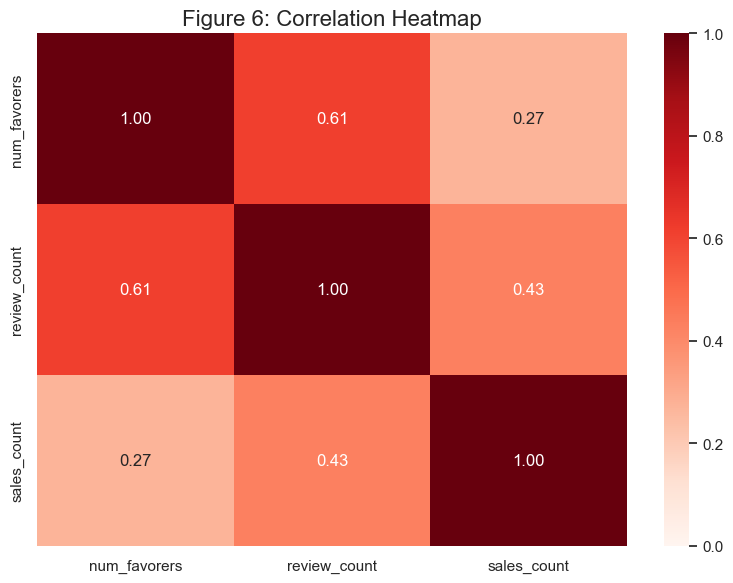

In [103]:
#correlation heatmap (num_favorers, review_count, sales_count)
corr_cols = ['num_favorers', 'review_count', 'sales_count']
corr_matrix = df[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Reds', fmt=".2f", vmin=0, vmax=1)
plt.title("Figure 6: Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

Simple regression model to predict sales, a linear regression model with:
- target variable: `sales_count`
- predictors: `listing_active_count`, `num_favorers`, `review_count`.

This is not a production-ready model, but it provides a first approximation  
of how these features combine to explain variation in sales.

Final dataset shape for modeling: (6250, 3)
Linear Regression Model Performance:
Features: ['listing_active_count', 'num_favorers', 'review_count']

Coefficients:
  listing_active_count: 0.3089
  num_favorers: 1.1990
  review_count: 1.3241

Intercept: 1.5170
R-squared: 0.2620
Mean Absolute Error (MAE): 1.72
Root Mean Squared Error (RMSE): 3.54


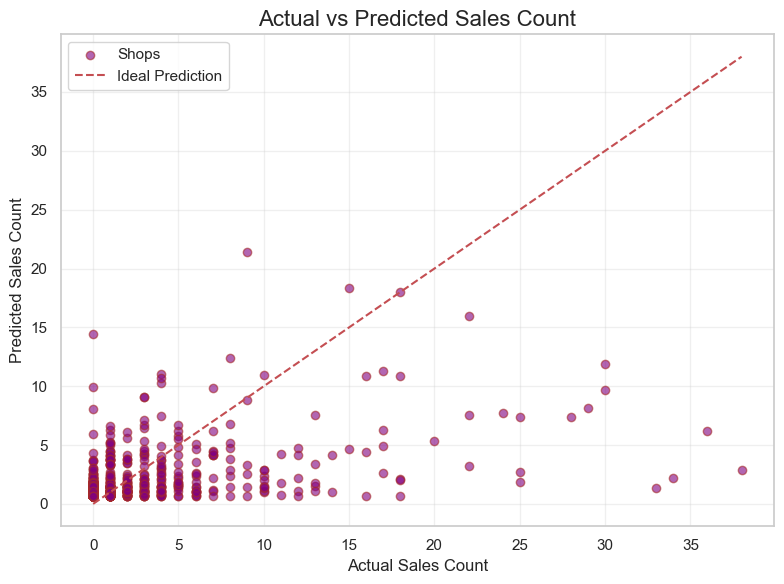

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#list of basic features for regression
feature_cols = ['listing_active_count', 'num_favorers', 'review_count']
model_df = df[feature_cols + ['sales_count']].dropna().copy()
#remove top 1% outliers in sales_count
sales_threshold = model_df['sales_count'].quantile(0.99)
model_df = model_df[model_df['sales_count'] <= sales_threshold]
X = model_df[feature_cols]
y = model_df['sales_count']
print("Final dataset shape for modeling:", X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred = lin_reg.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression Model Performance:")
print('Features:', feature_cols)
print('\nCoefficients:')
for feature, coef in zip(feature_cols, lin_reg.coef_):
    print(f"  {feature}: {coef:.4f}")
print(f"\nIntercept: {lin_reg.intercept_:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
#actual vs predicted sales scatter plot
y_pred_series = pd.Series(y_pred, index=y_test.index)
# Plotting actual vs predicted sales
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_series, alpha=0.6, color='purple', edgecolor='brown', label='Shops')
max_val = max(y_test.max(), y_pred_series.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal Prediction')
plt.title("Actual vs Predicted Sales Count", fontsize=16)
plt.xlabel("Actual Sales Count", fontsize=12)
plt.ylabel("Predicted Sales Count", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Due to problems with simple regression model I will try different approach, Random Forest Regressor

Random Forest Regressor Model Performance:
mae: 3.13
rmse: 14.77
r2: 0.2169


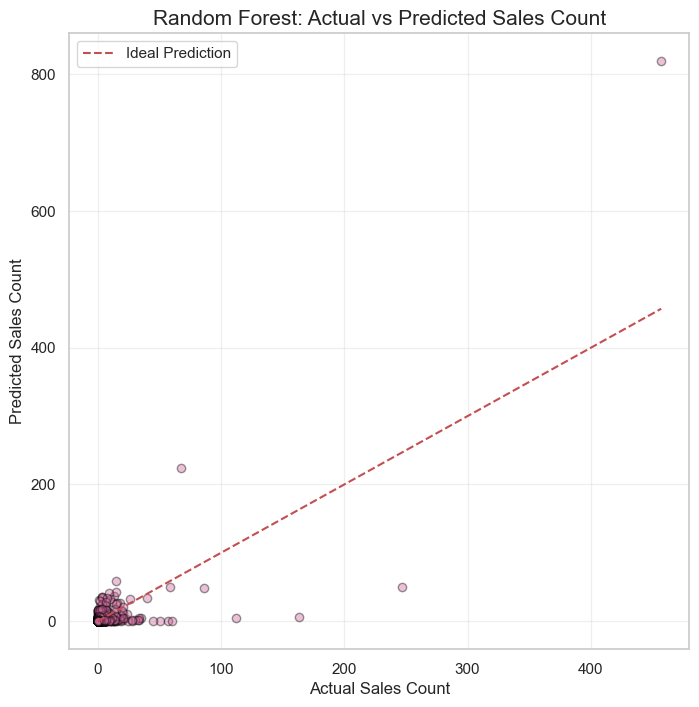

C:\Users\Karolina\AppData\Local\Temp\ipykernel_21328\2562823400.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="Reds_r")


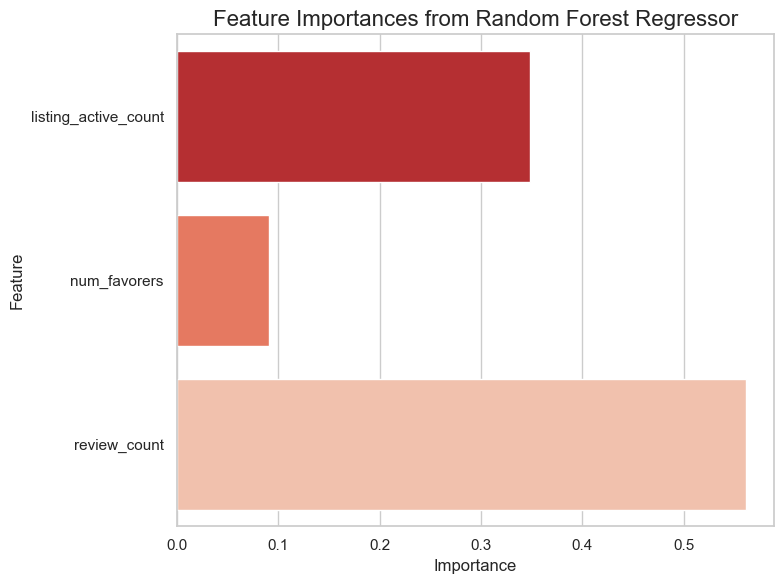

In [113]:
#random forest regressor model
from sklearn.ensemble import RandomForestRegressor
#features & target
x=df[['listing_active_count', 'num_favorers', 'review_count']]
y=df['sales_count']
#train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#random forest regressor
rf_reg = RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_split=5, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Model Performance:")
print(f"mae: {mae_rf:.2f}")
print(f"rmse: {rmse_rf:.2f}")
print(f"r2: {r2_rf:.4f}")
#actual vs predicted sales scatter plot for random forest
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_rf, alpha=0.4, color="#cc6699", edgecolor="black")
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label="Ideal Prediction")

plt.xlabel("Actual Sales Count", fontsize=12)
plt.ylabel("Predicted Sales Count", fontsize=12)
plt.title("Random Forest: Actual vs Predicted Sales Count", fontsize=15)
plt.legend()
plt.grid(alpha=0.3)

plt.show()
#feature importance
importances = rf_reg.feature_importances_
feature_names = x.columns
plt.figure(figsize=(8, 6))
sns.barplot(x=importances, y=feature_names, palette="Reds_r")
plt.title("Feature Importances from Random Forest Regressor", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


Summary of EDA findings

`Sales distribution is highly skewed`
The vast majority of shops achieve very low sales (0–5), while a small number reach extremely high values (200+). This imbalance affects both visualisations and modelling.

`Country does not strongly determine performance`
Although most shops come from the United States, sales variation within each country is large, suggesting that geography alone is not a meaningful predictor.

`Active listings show only a weak positive correlation with sales
Shops with more products tend to sell slightly more, but the relationship is not strong and many high-listing shops still have low sales`

`Marketing usage (“sale message”) is associated with better outcomes`
Shops with marketing enabled show higher median sales and higher review counts. Shops without marketing often have zero sales.

`Customer engagement correlates with sales`
Both favourites (num_favorers) and reviews (review_count) show positive correlations with sales, indicating that engagement is a meaningful indicator of performance.

`Feature correlations overall are low`
No single numeric feature strongly predicts sales, highlighting the complexity of Etsy shop performance and the limited scope of available data.